In [284]:
import os
import sys
import csv
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import homogeneity_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.decomposition import NMF, PCA
from k_means_constrained import KMeansConstrained
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mgdielman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Project Topic #
This project is investigating the ability to determine the author of an article from the raw text of the article. We will be using three types of supervised learning models to attempt to classify the articles by author, a M-Means model, a DBSCAN model, and a Random Forest as a supervised comparison.

This work extends a previous project working with supervised learning for determining authorship. In that project, we used vectorized word counts in order to determine the author of an article, but discovered that the model had difficulty distinguishing between authors when the subject matter was too similar. As discussed in that project, authorship analysis is an important subject in machine learning, and has been performed by experts without computer assistance in the attribution of historical works and forensic science.

For this project we purposefully limit ourselves to not using the actual text of the articles as the previous project already proved effective at analyzing those features. We want to see if we can focus more on stylistic elements than text.

# Data #
The data used for this project is the Reuters 50 50 dataset which contains 100 text file copies articles by each of 50 Reuters authors. The data comes split 50/50 into train and test subdirectories, but those were combined for this test so that a custom train test split can be generated. The data is loaded below into two columns, author, which contains the directory name of the author, and the text, which contains the content of the raw text files.

The data is available under a Creative Commons Attribution 4.0 Internation license and can be accessed at https://archive.ics.uci.edu/dataset/217/reuter+50+50.

<p style="text-align: center;">References</p>

Liu,Zhi. (2011). Reuter_50_50. UCI Machine Learning Repository. https://doi.org/10.24432/C5DS42.

# Data Cleaning #
The dataset used is provided starting in a mostly clean state, there are no null values for articles and the size and balance of the data categories are known to be balanced by the nature of the dataset. However there is some routine cleaning we need to perform for Natural Language Processing.

Step 1: We load the data file by file into arrays, as it is provided in a non-tabular format. The arrays are then converted into a dataframe with two columns (author and text) and 5000 rows (50 authors with 100 articles each)

Step 2: We perform feature creation, starting by counting the portion of the articles that are given special character.

Step 3: After extracting special characters and punctuation, we obtain the ratio of stop words (words like "and" or "the") to total words.

Step 4: We generate the mean, median, 1st quartile, and 3rd quartile word lengths.

Step 5: We create a feature to represent how varied word choice is in an article, represented by the number of unique words per number of total words.

Step 6: Finally we create boxplots of each feature we have created, and drop any that do not appear to differ between authors, or those that are clearly colinear like open and close parentheses.

In [173]:
#Loads data from .txt files
y_array = []
x_array = []
for directory in os.listdir('Reuters Data'):
    author = directory
    for file in os.listdir('Reuters Data/'+author):
        file_name = os.path.join('Reuters Data/'+author, file)
        file_content = open(file_name)
        y_array.append(author)
        x_array.append(file_content.read())
        file_content.close()

dictionary = {'author':y_array, 'text':x_array}
df = pd.DataFrame(dictionary)
print(df)

          author                                               text
0      NickLouth  Hordes of aggressive telephone resellers bangi...
1      NickLouth  AT&amp;T Corp. on Wednesday said basic U.S. ra...
2      NickLouth  The $25 billion cable TV industry, once consid...
3      NickLouth  Citizens Utilities Co said on Thursday that it...
4      NickLouth  Worries about regulatory hurdles and a lengthy...
...          ...                                                ...
4995  TimFarrand  London Clubs International, which runs the Lon...
4996  TimFarrand  David Jones, chief executive of British fashio...
4997  TimFarrand  Tobacco to insurance group B.A.T Industries Pl...
4998  TimFarrand  Ice cream had a sad time in Europe this summer...
4999  TimFarrand  Imperial Tobacco Group Plc, demerged from Hans...

[5000 rows x 2 columns]


In [174]:
#Feature generation component
stops = stopwords.words('english')
stemmer = PorterStemmer()
style_df = df.copy()
style_df['article_length'] = df.text.str.split().str.len()
style_df['comma_count'] = df.text.str.count('\,')/style_df.article_length
style_df['period_count'] = df.text.str.count('\.')/style_df.article_length
style_df['question_count'] = df.text.str.count('\?')/style_df.article_length
style_df['exclamation_count'] = df.text.str.count('\!')/style_df.article_length
style_df['backslash_count'] = df.text.str.count('\/')/style_df.article_length
style_df['at_count'] = df.text.str.count('\@')/style_df.article_length
style_df['number_count'] = df.text.str.count('\#')/style_df.article_length
style_df['percent_count'] = df.text.str.count('\%')/style_df.article_length
style_df['caret_count'] = df.text.str.count('\^')/style_df.article_length
style_df['asterisk_count'] = df.text.str.count('\*')/style_df.article_length
style_df['oparen_count'] = df.text.str.count('\(')/style_df.article_length
style_df['cparen_count'] = df.text.str.count('\)')/style_df.article_length
style_df['cleaned_text'] = style_df['text'].str.replace('[^a-zA-Z\d\s]','', regex=True)
style_df['unstopped_text'] = style_df.cleaned_text.apply(lambda x: ' '.join([text for text in x.split() if text not in (stops)]))
style_df['char_count'] = style_df.cleaned_text.str.len()
style_df['avg_word_len'] = style_df.unstopped_text.str.split().apply(lambda x: np.mean([len(y) for y in x]))
style_df['med_word_len'] = style_df.unstopped_text.str.split().apply(lambda x: np.median([len(y) for y in x]))
style_df['1q_word_len'] = style_df.unstopped_text.str.split().apply(lambda x: np.percentile([len(y) for y in x], 25))
style_df['3q_word_len'] = style_df.unstopped_text.str.split().apply(lambda x: np.percentile([len(y) for y in x], 75))
style_df['stopword_ratio'] = style_df.unstopped_text.str.len()/style_df.cleaned_text.str.len()
style_df['cleaned_text'] = style_df.cleaned_text.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
style_df['vocabulary_ratio'] = style_df.cleaned_text.apply(lambda x: len(set(x.split())))/style_df.cleaned_text.str.split().str.len()
style_df['unstopped_text'] = style_df.unstopped_text.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
style_df['unstopped_vocabulary_ratio'] = style_df.unstopped_text.apply(lambda x: len(set(x.split())))/style_df.unstopped_text.str.split().str.len()
style_df = style_df.drop(columns=['text', 'unstopped_text', 'cleaned_text'])
print(style_df)

          author  article_length  comma_count  period_count  question_count  \
0      NickLouth             591     0.060914      0.042301             0.0   
1      NickLouth             605     0.056198      0.064463             0.0   
2      NickLouth             830     0.043373      0.043373             0.0   
3      NickLouth              63     0.031746      0.063492             0.0   
4      NickLouth             368     0.043478      0.051630             0.0   
...          ...             ...          ...           ...             ...   
4995  TimFarrand             427     0.035129      0.051522             0.0   
4996  TimFarrand             501     0.045908      0.055888             0.0   
4997  TimFarrand             497     0.028169      0.106640             0.0   
4998  TimFarrand             627     0.046252      0.046252             0.0   
4999  TimFarrand             382     0.057592      0.049738             0.0   

      exclamation_count  backslash_count  at_count 

<Axes: title={'center': 'article_length'}, xlabel='author'>

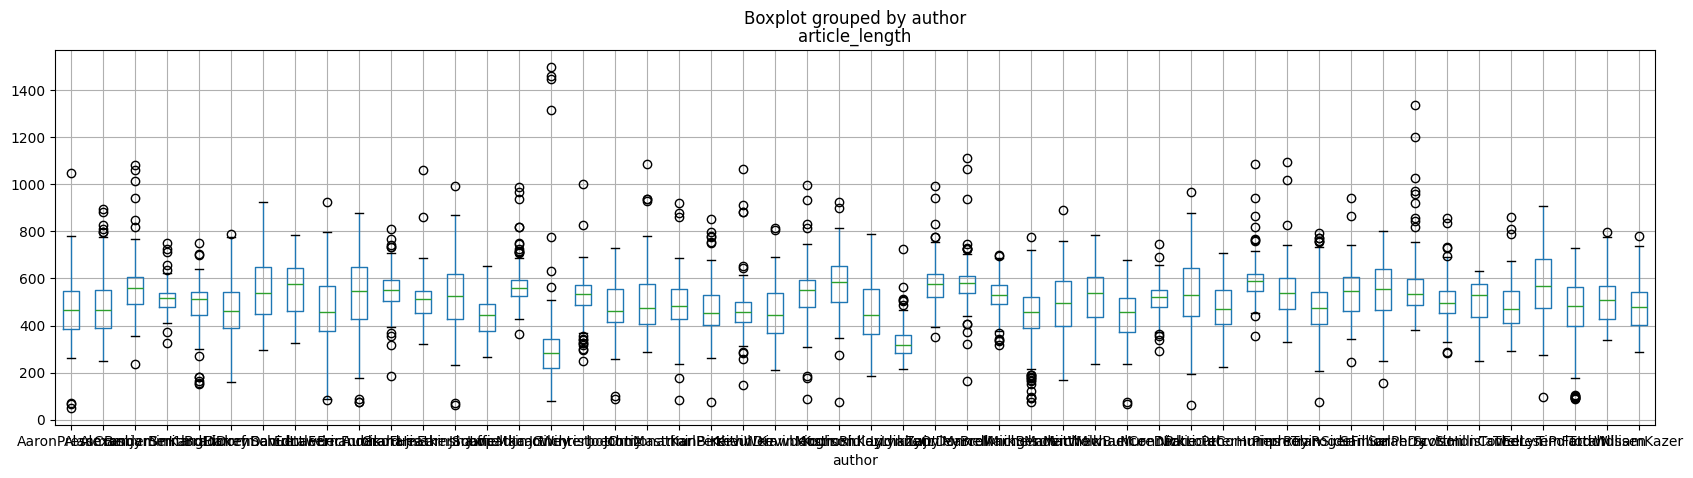

In [152]:
#Boxplot generation
style_df.boxplot(column = 'article_length', by = 'author', figsize = (20,5))

<Axes: title={'center': 'comma_count'}, xlabel='author'>

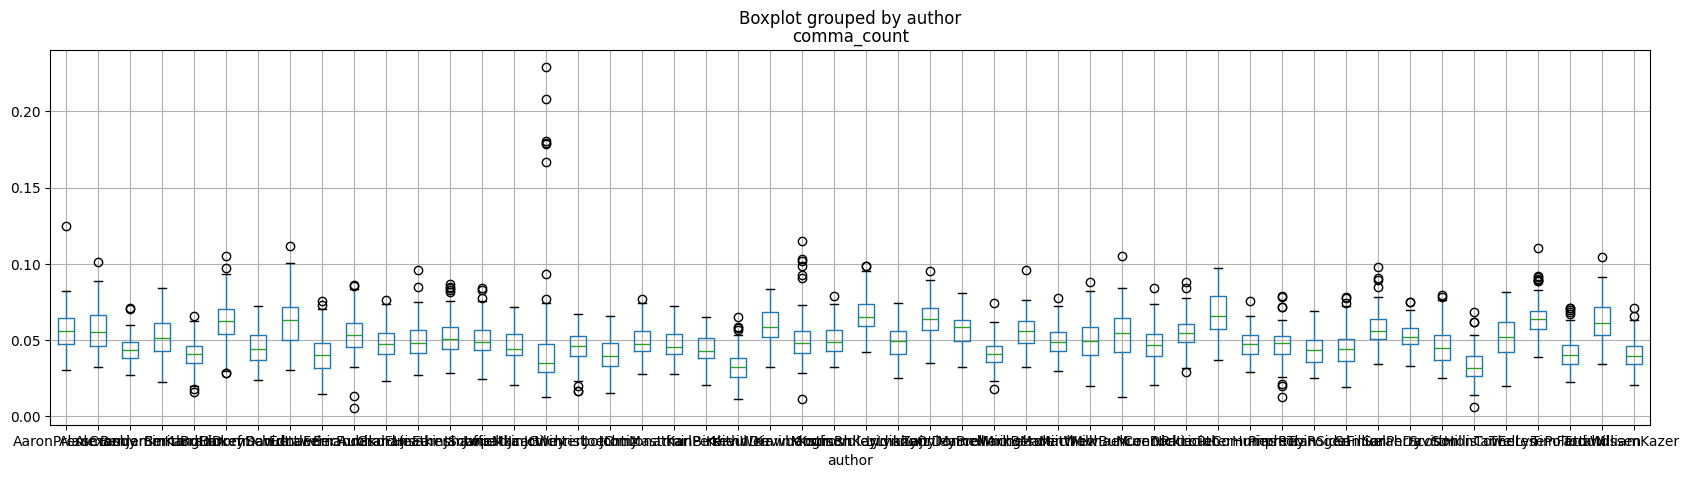

In [153]:
style_df.boxplot(column = 'comma_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'period_count'}, xlabel='author'>

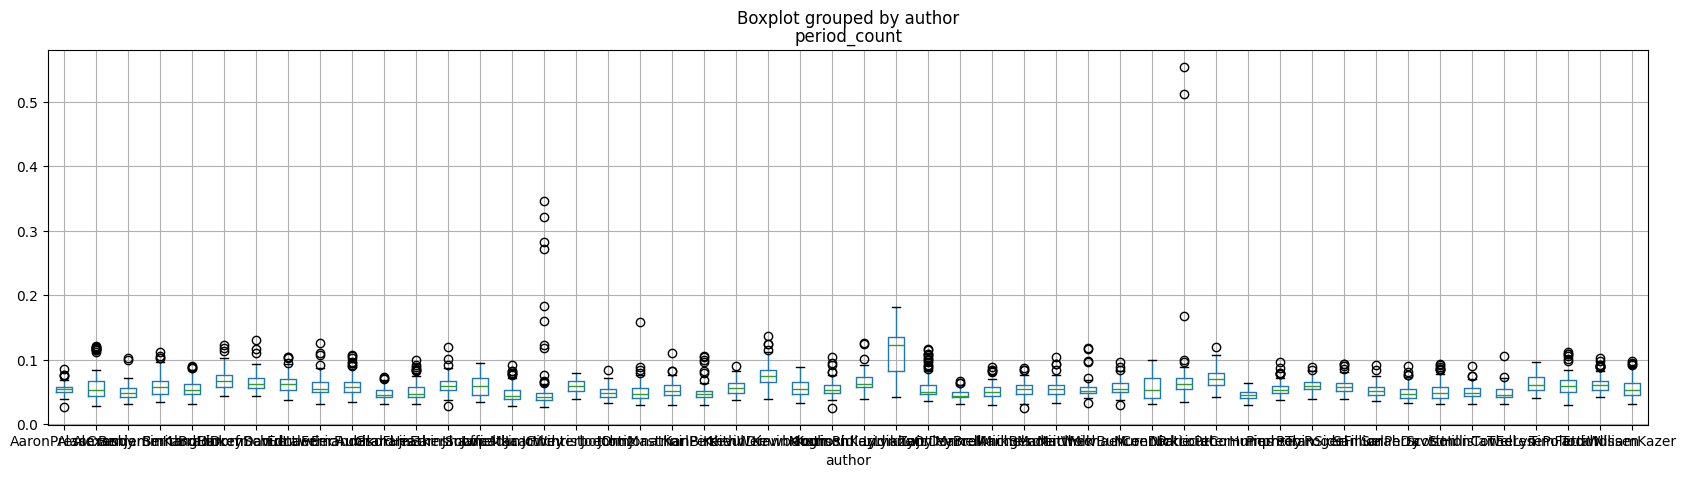

In [154]:
style_df.boxplot(column = 'period_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'question_count'}, xlabel='author'>

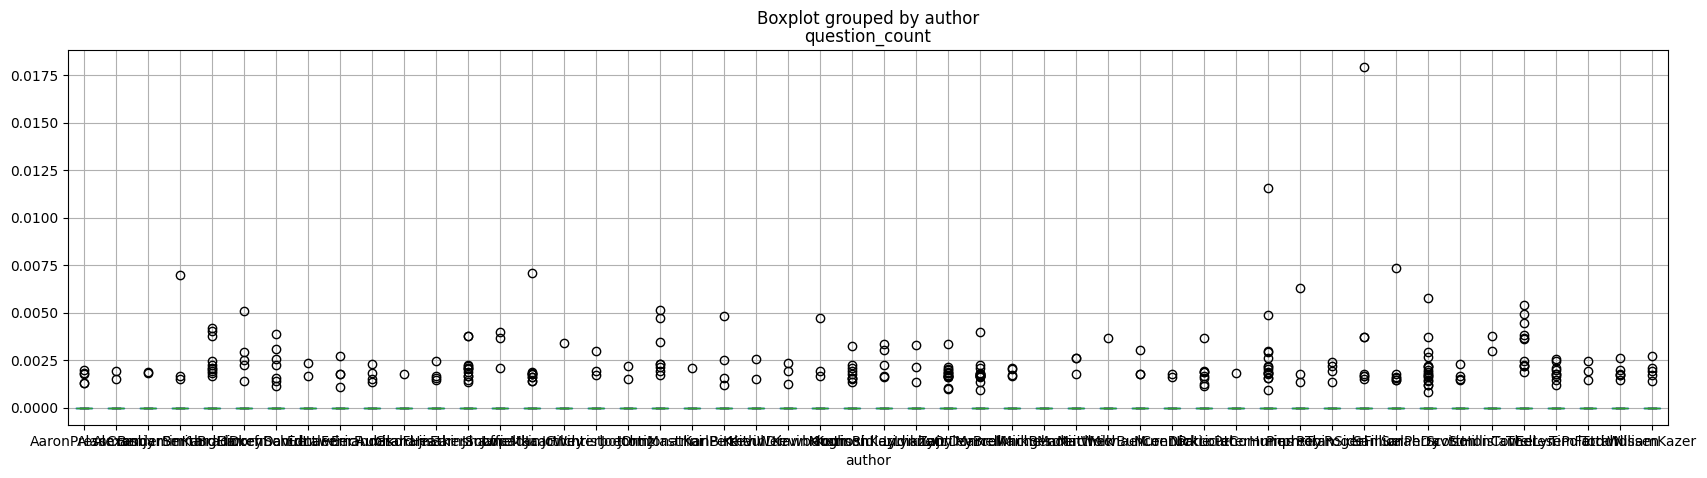

In [155]:
style_df.boxplot(column = 'question_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'exclamation_count'}, xlabel='author'>

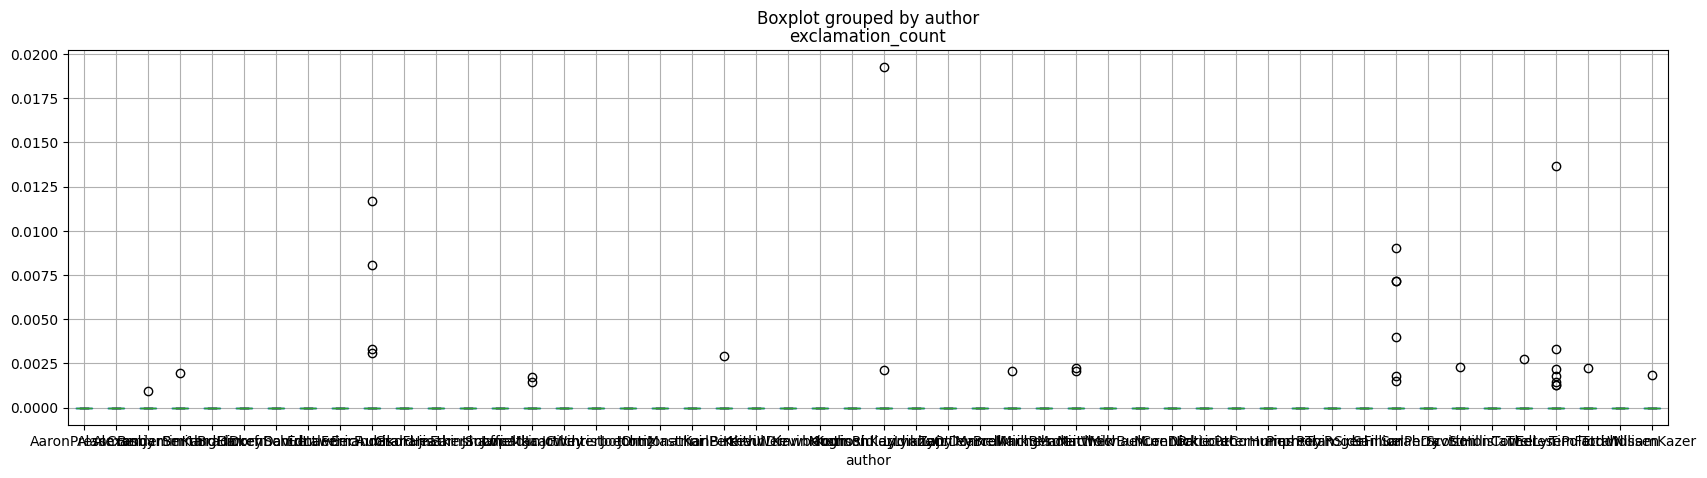

In [156]:
style_df.boxplot(column = 'exclamation_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'backslash_count'}, xlabel='author'>

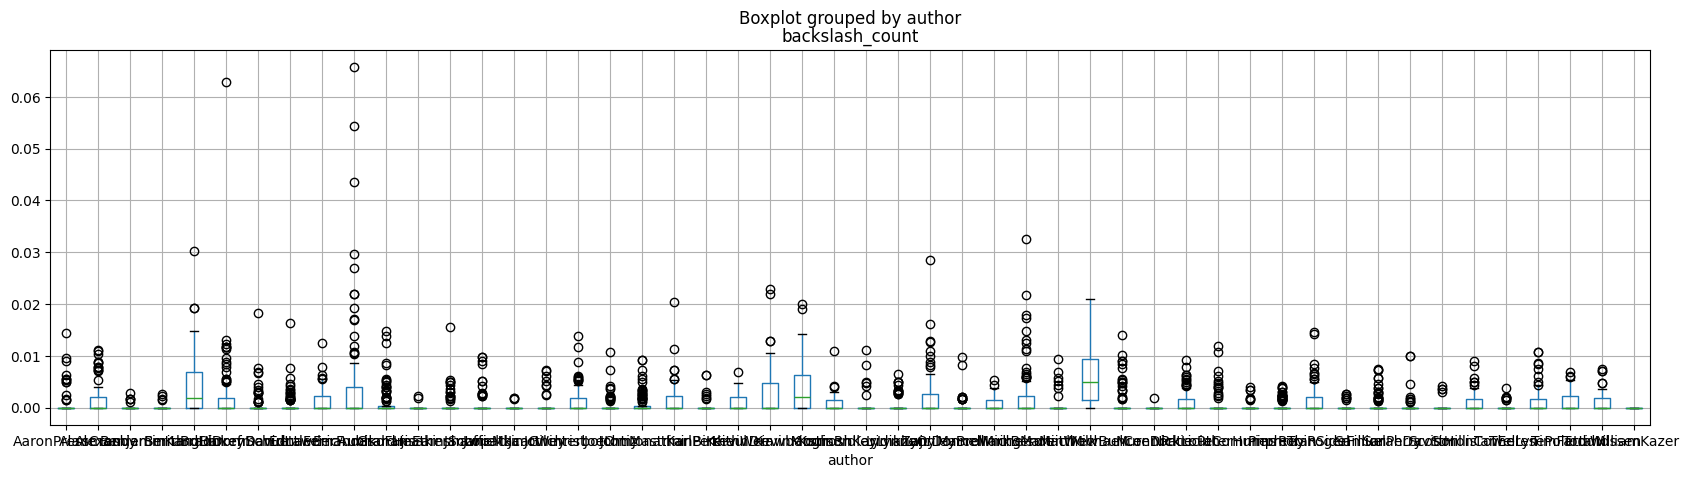

In [157]:
style_df.boxplot(column = 'backslash_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'at_count'}, xlabel='author'>

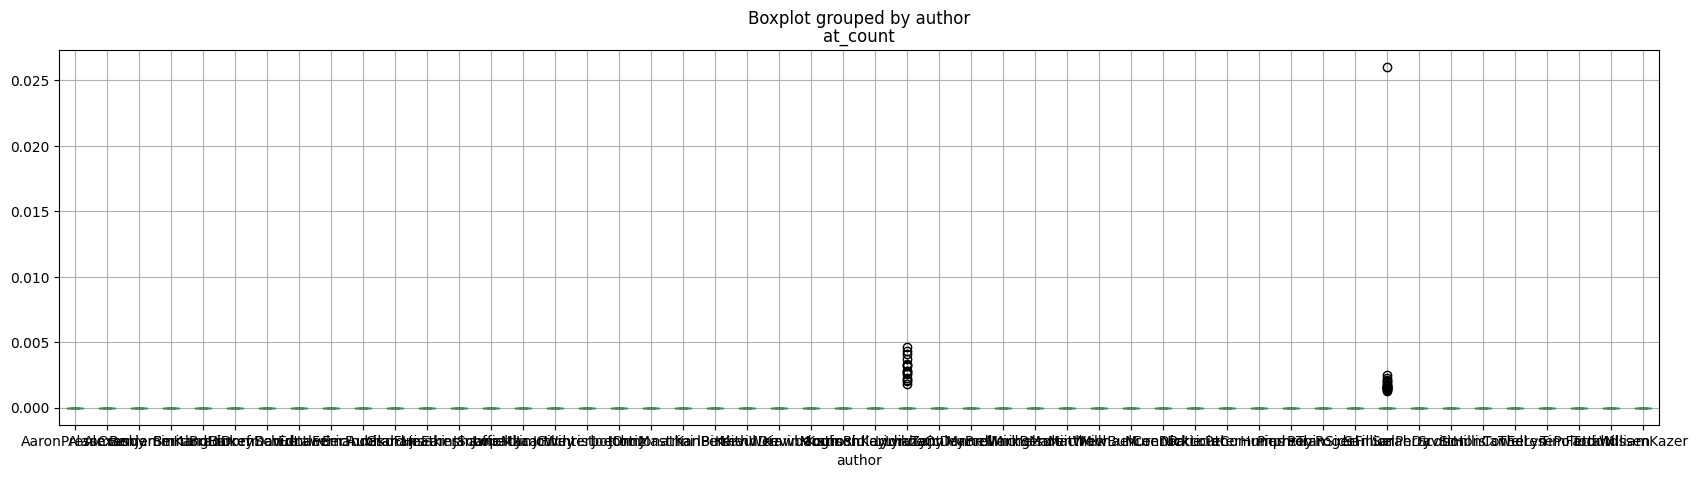

In [158]:
style_df.boxplot(column = 'at_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'number_count'}, xlabel='author'>

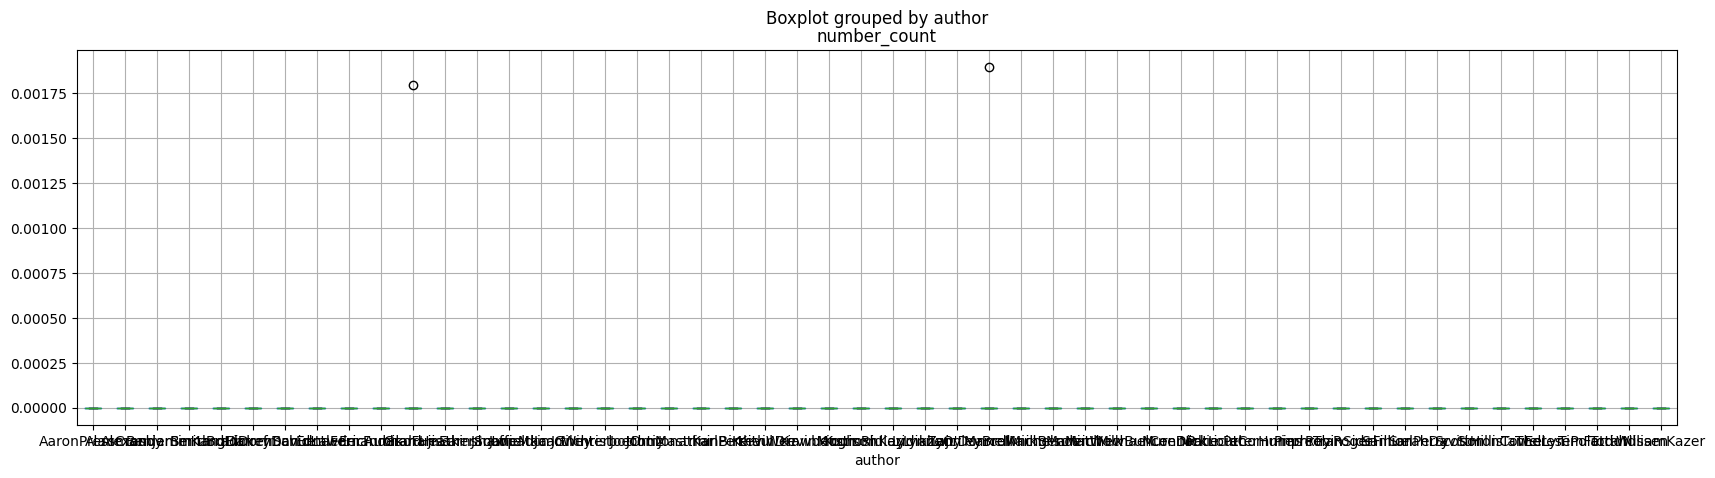

In [159]:
style_df.boxplot(column = 'number_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'percent_count'}, xlabel='author'>

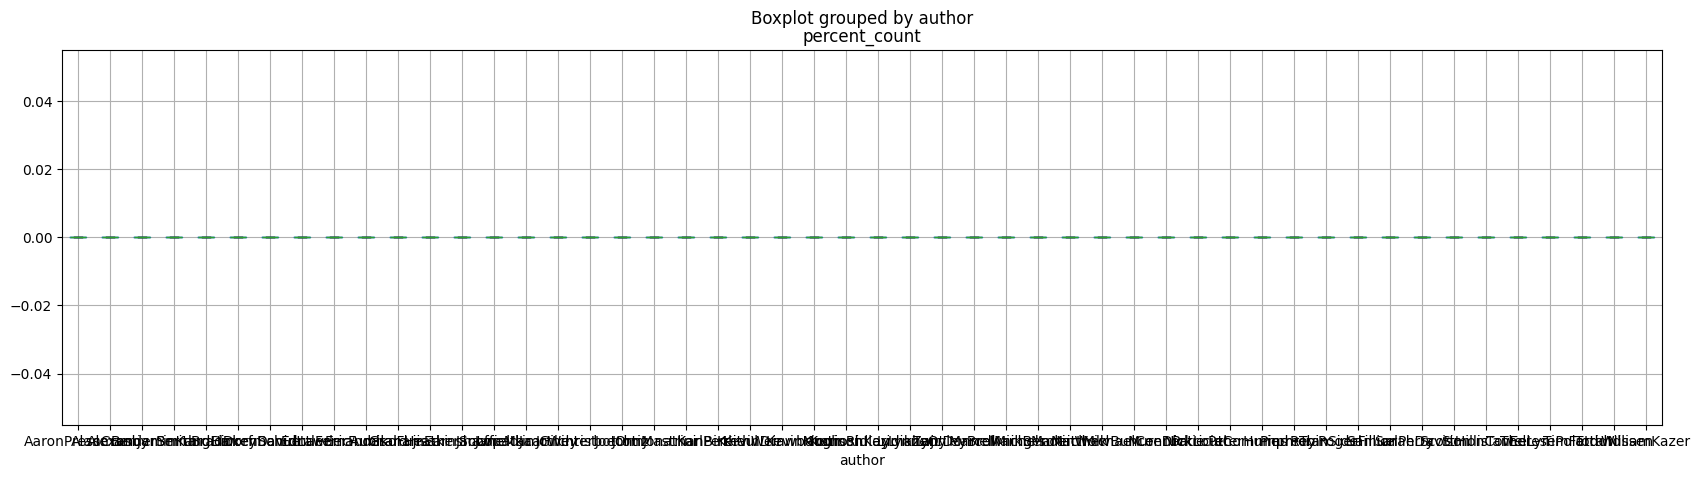

In [160]:
style_df.boxplot(column = 'percent_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'caret_count'}, xlabel='author'>

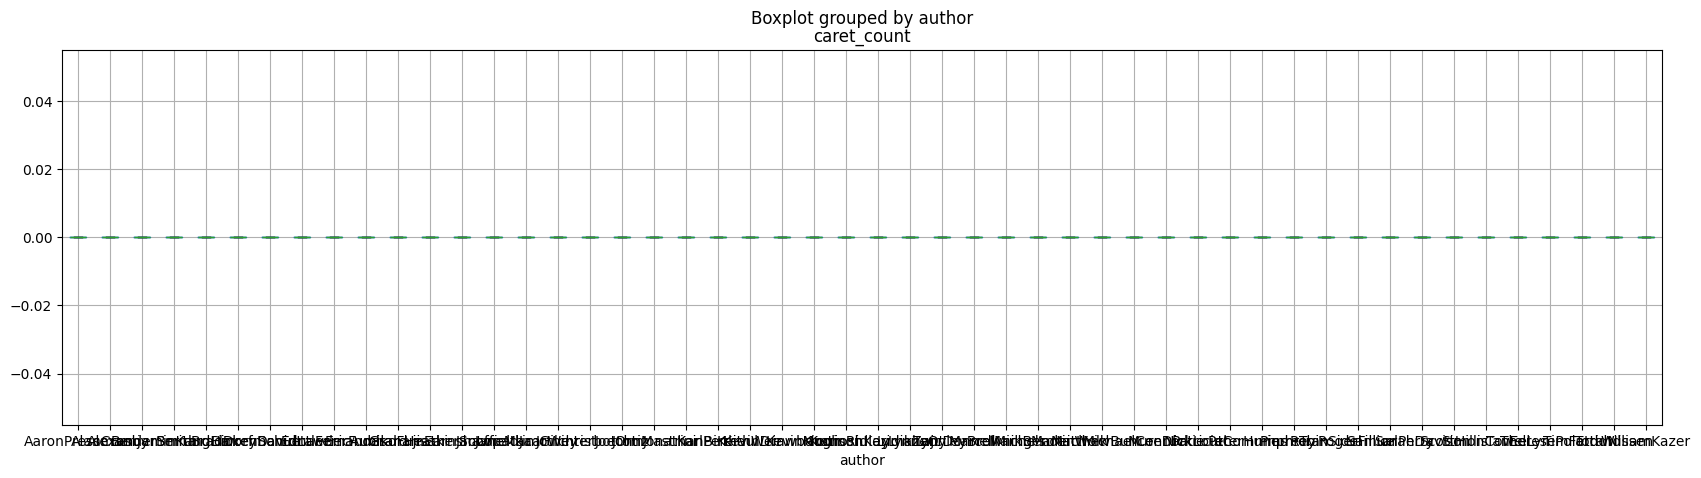

In [161]:
style_df.boxplot(column = 'caret_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'asterisk_count'}, xlabel='author'>

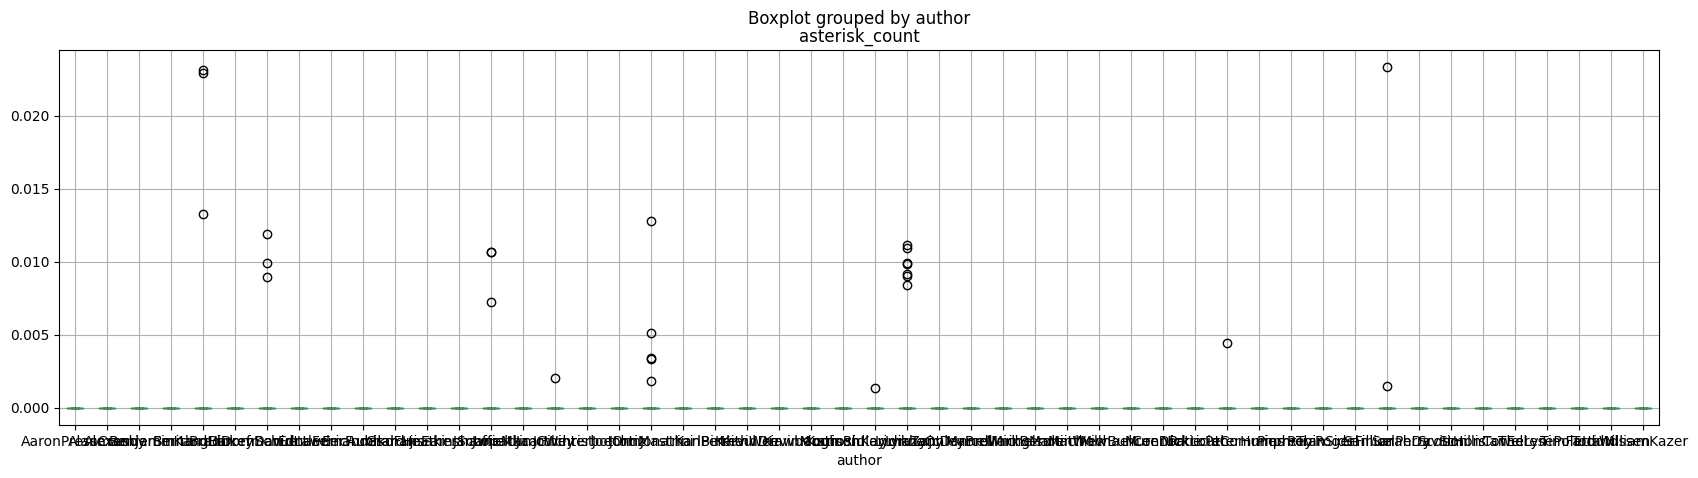

In [162]:
style_df.boxplot(column = 'asterisk_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'oparen_count'}, xlabel='author'>

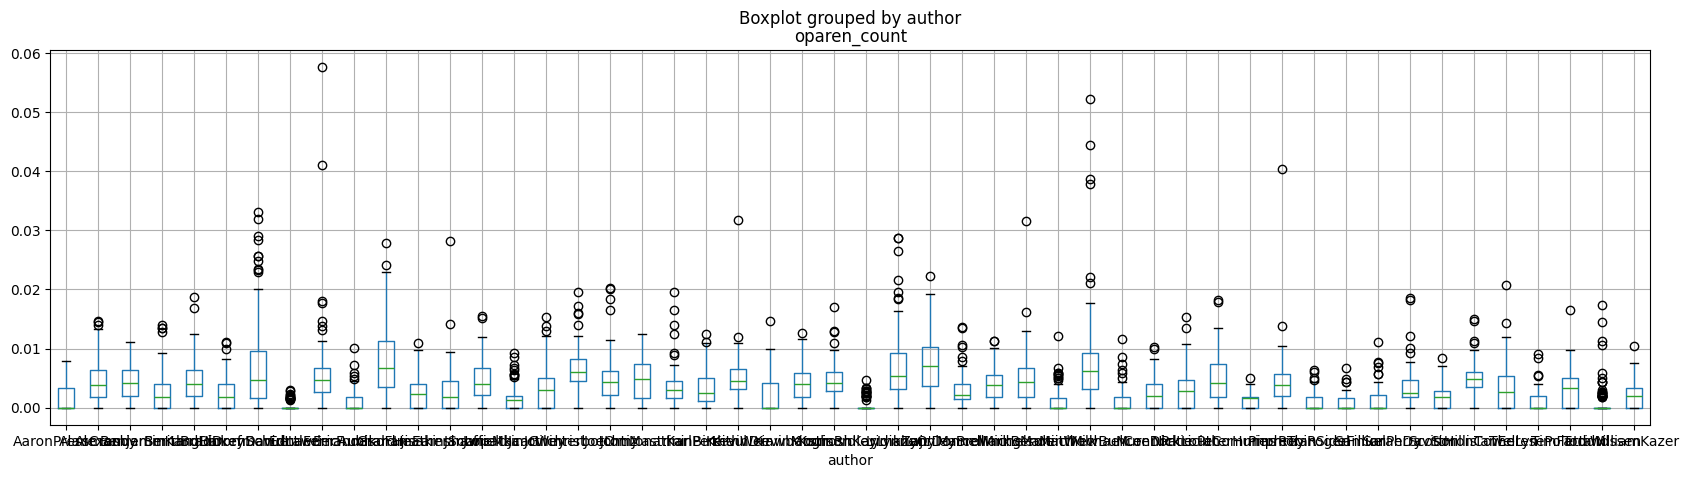

In [163]:
style_df.boxplot(column = 'oparen_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'cparen_count'}, xlabel='author'>

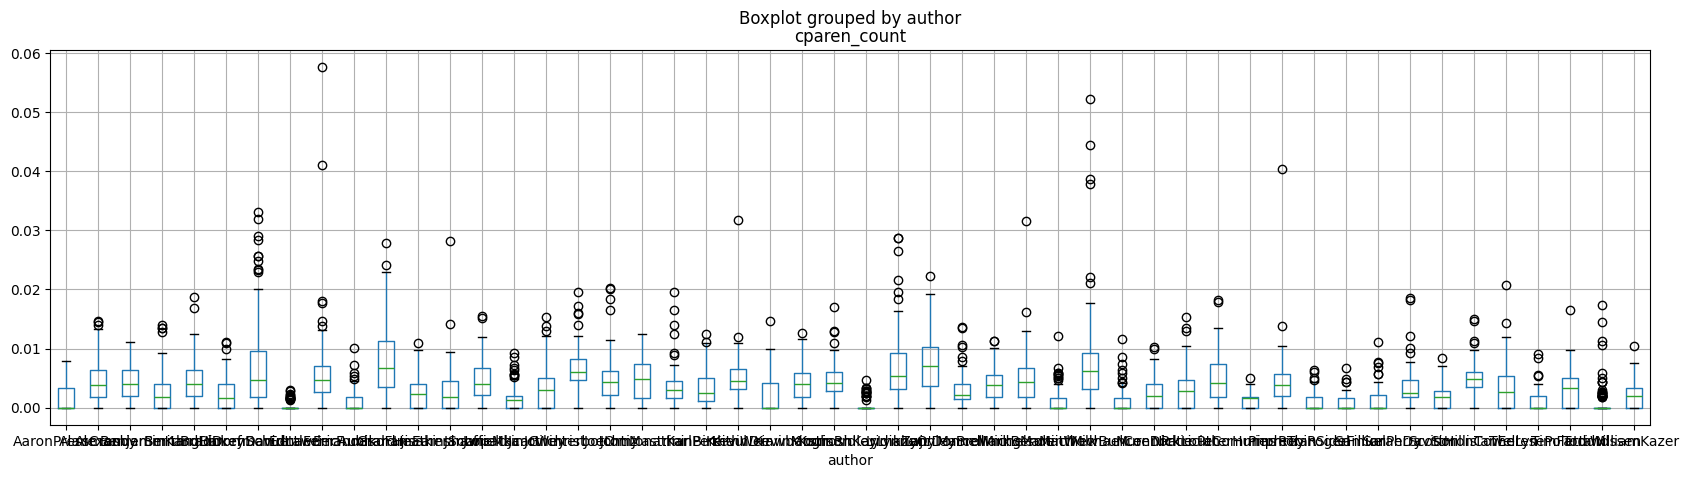

In [164]:
style_df.boxplot(column = 'cparen_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'char_count'}, xlabel='author'>

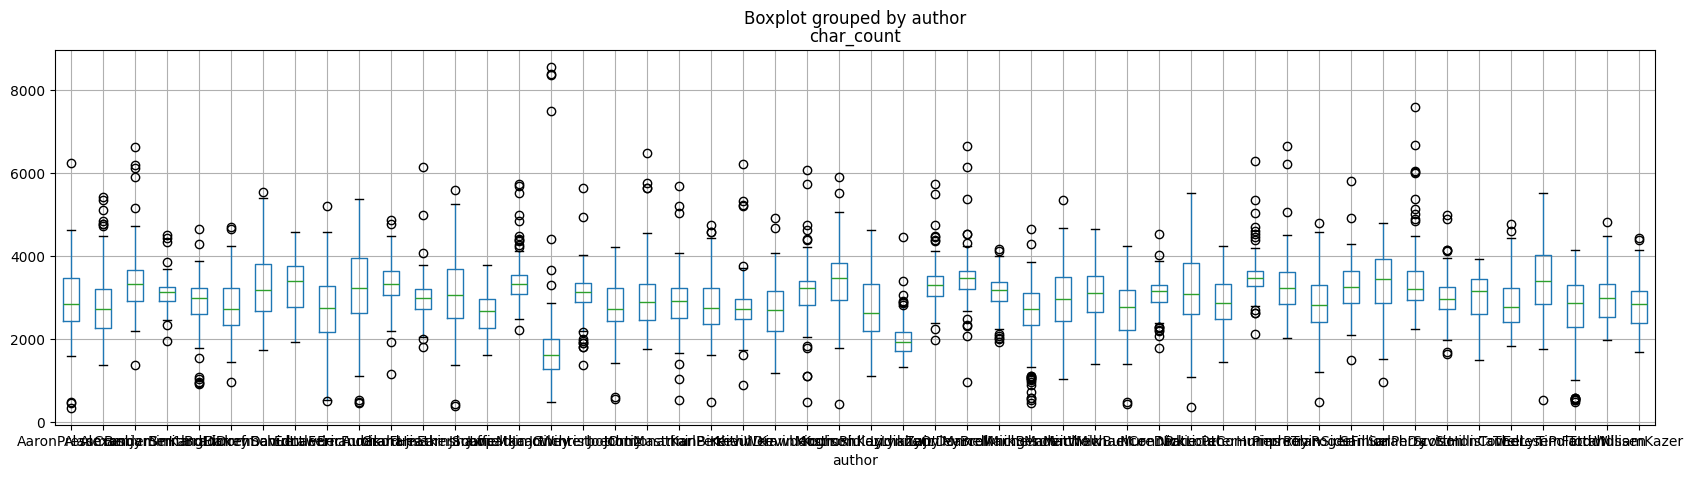

In [165]:
style_df.boxplot(column = 'char_count', by = 'author', figsize = (20,5))

<Axes: title={'center': 'avg_word_len'}, xlabel='author'>

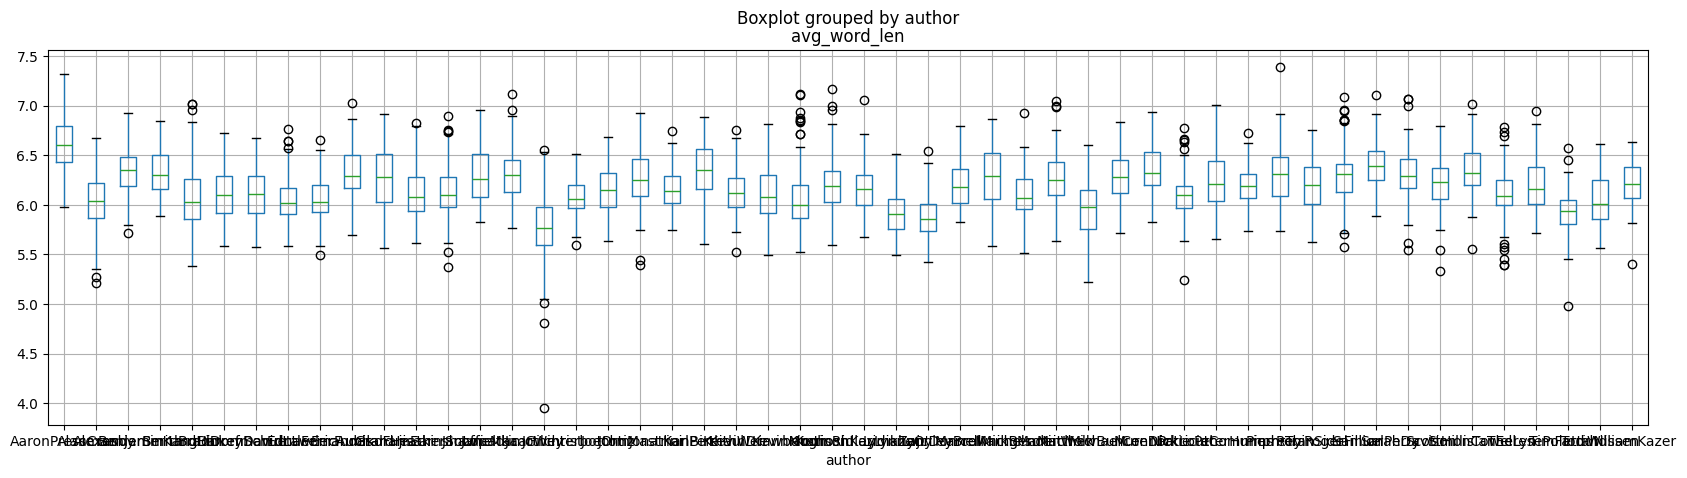

In [175]:
style_df.boxplot(column = 'avg_word_len', by = 'author', figsize = (20,5))

<Axes: title={'center': 'med_word_len'}, xlabel='author'>

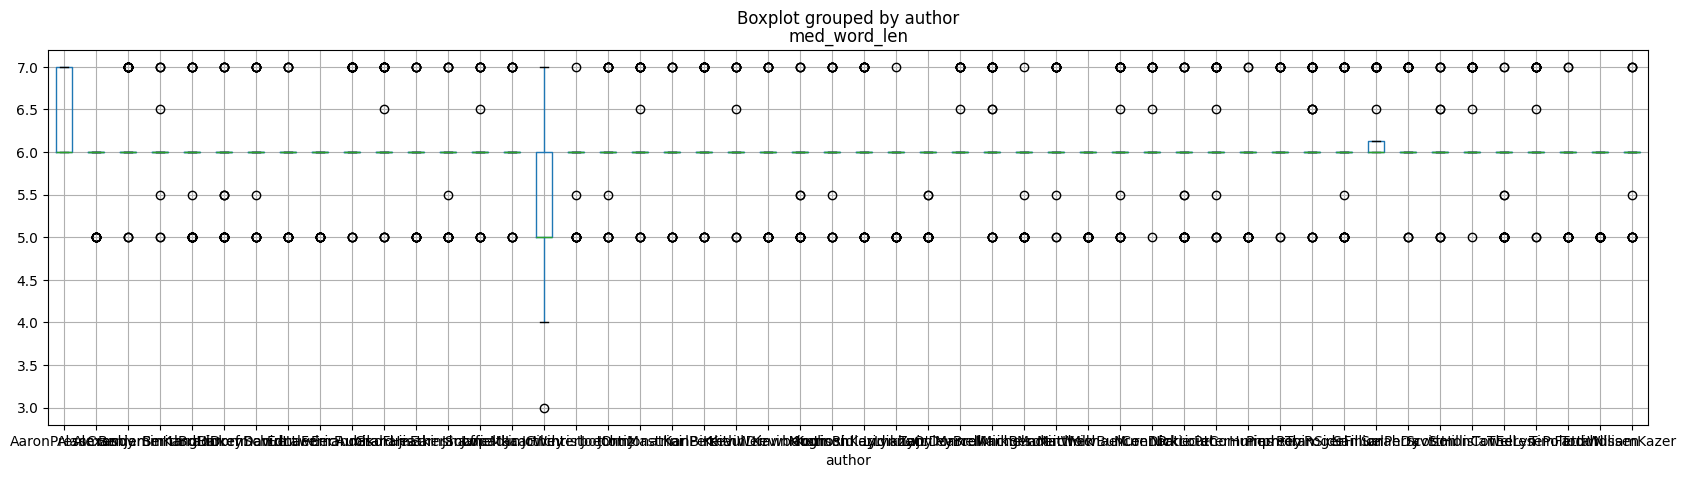

In [176]:
style_df.boxplot(column = 'med_word_len', by = 'author', figsize = (20,5))

<Axes: title={'center': '1q_word_len'}, xlabel='author'>

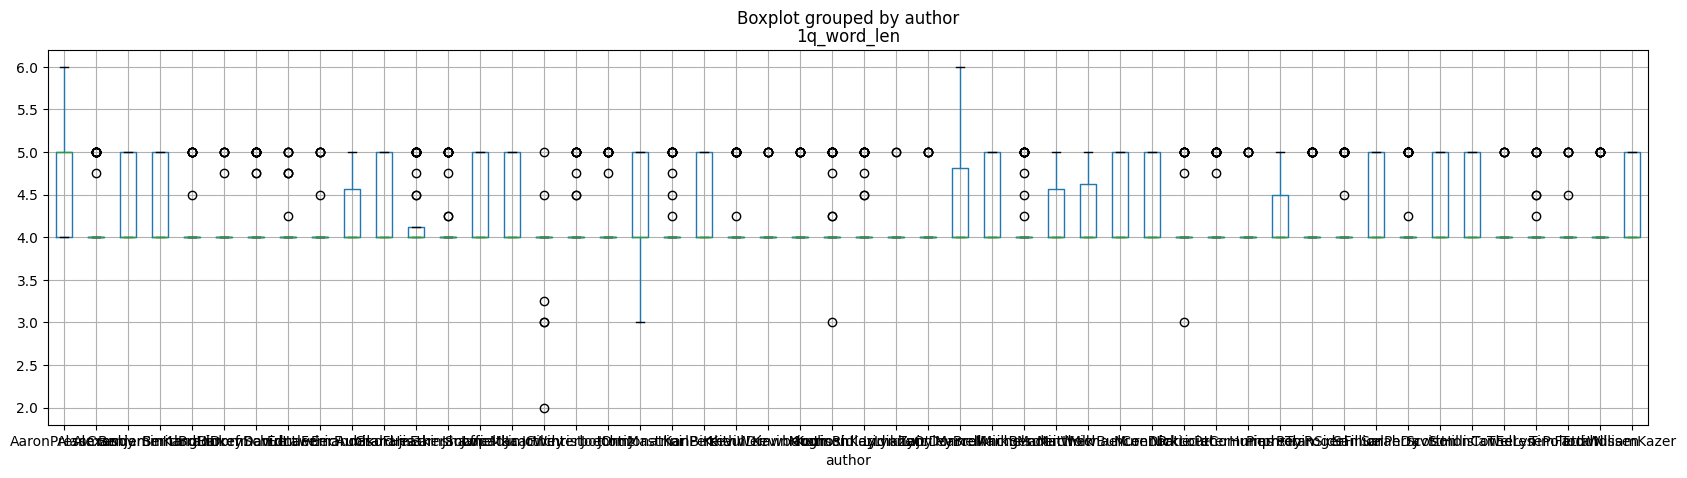

In [177]:
style_df.boxplot(column = '1q_word_len', by = 'author', figsize = (20,5))

<Axes: title={'center': '3q_word_len'}, xlabel='author'>

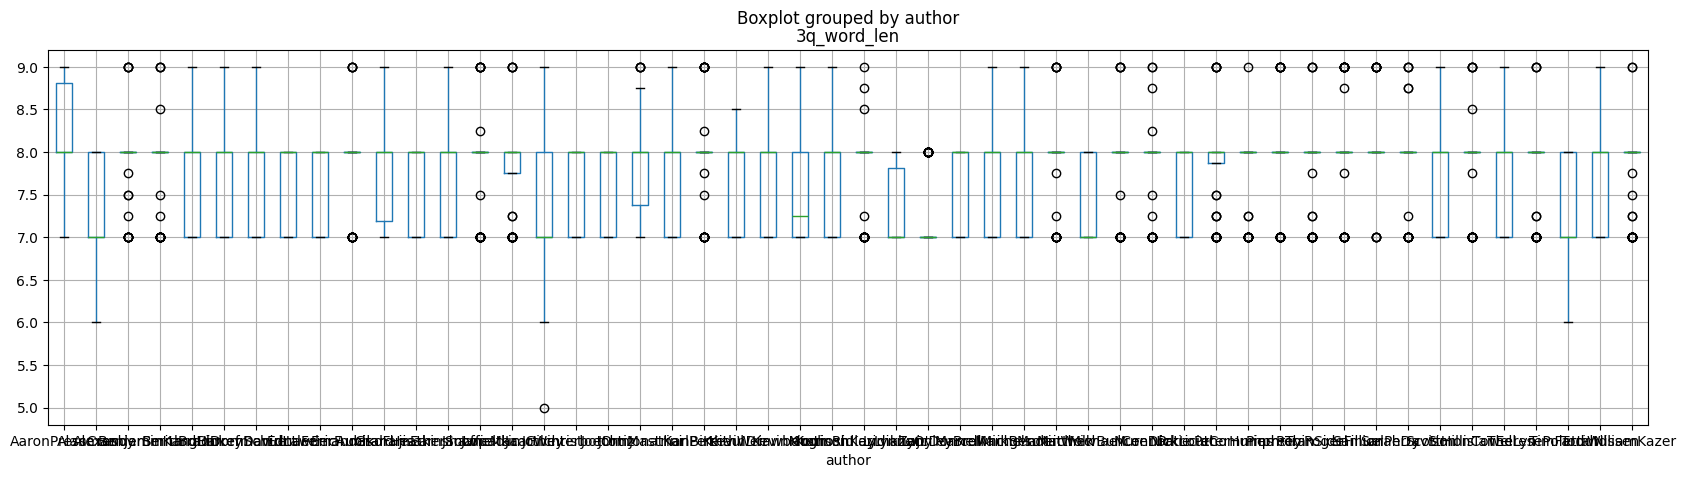

In [178]:
style_df.boxplot(column = '3q_word_len', by = 'author', figsize = (20,5))

<Axes: title={'center': 'stopword_ratio'}, xlabel='author'>

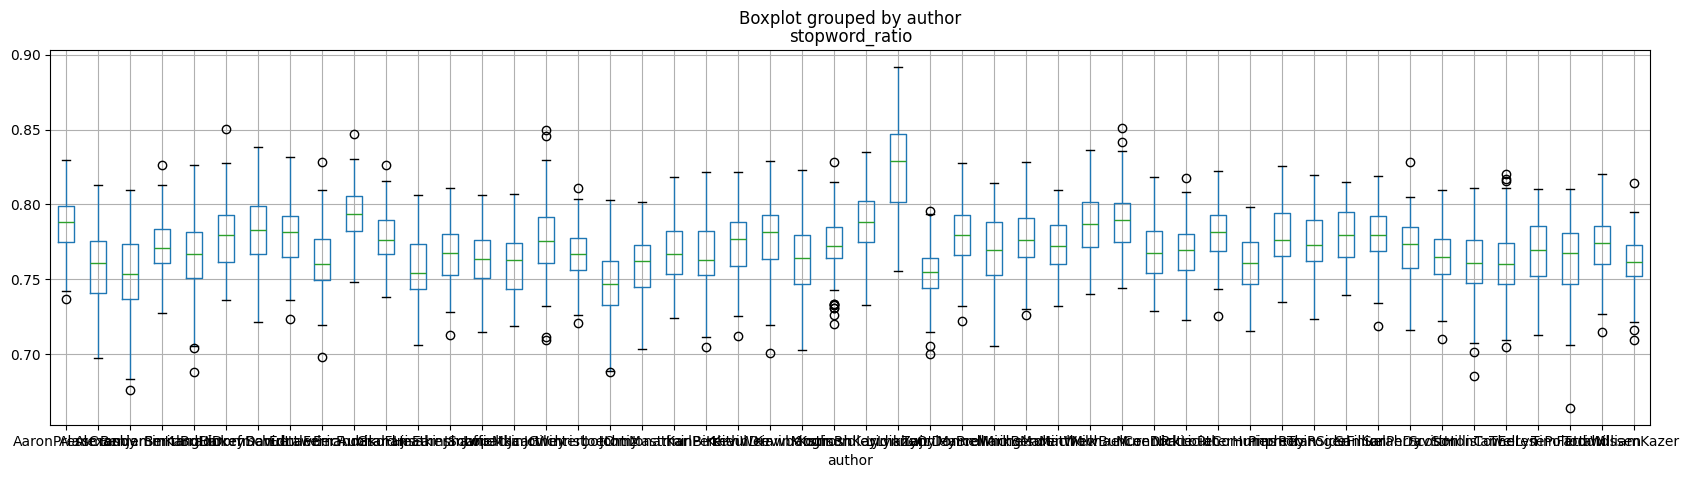

In [179]:
style_df.boxplot(column = 'stopword_ratio', by = 'author', figsize = (20,5))

<Axes: title={'center': 'vocabulary_ratio'}, xlabel='author'>

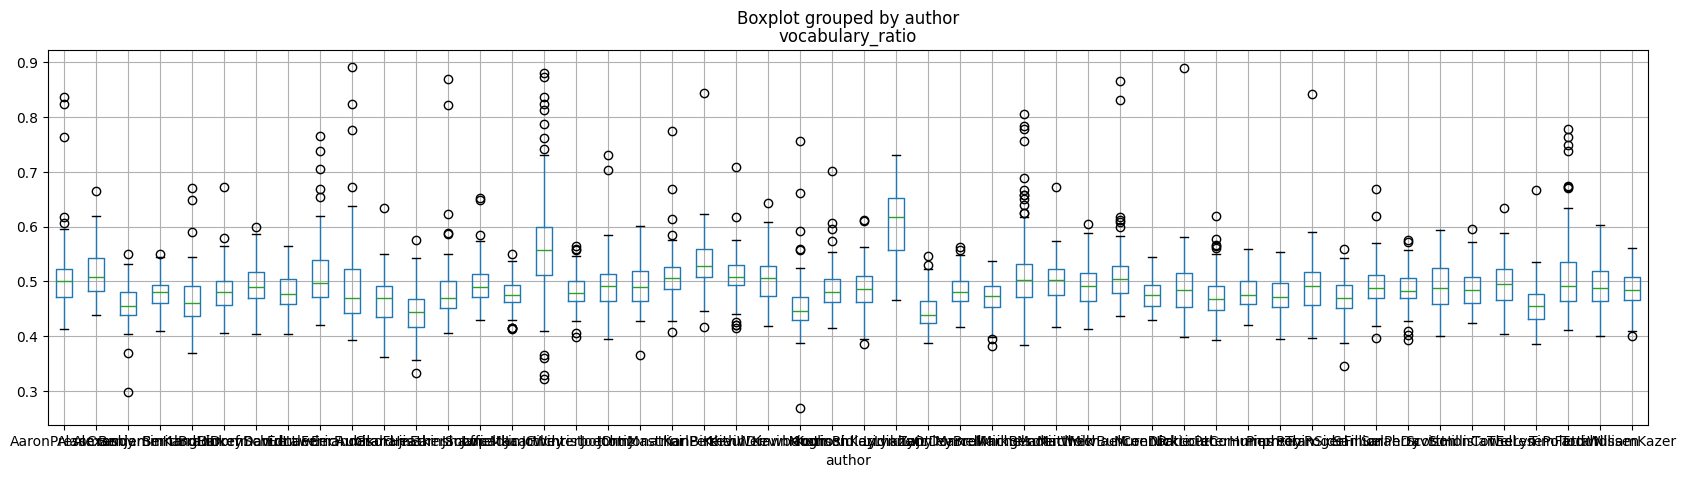

In [180]:
style_df.boxplot(column = 'vocabulary_ratio', by = 'author', figsize = (20,5))

<Axes: title={'center': 'unstopped_vocabulary_ratio'}, xlabel='author'>

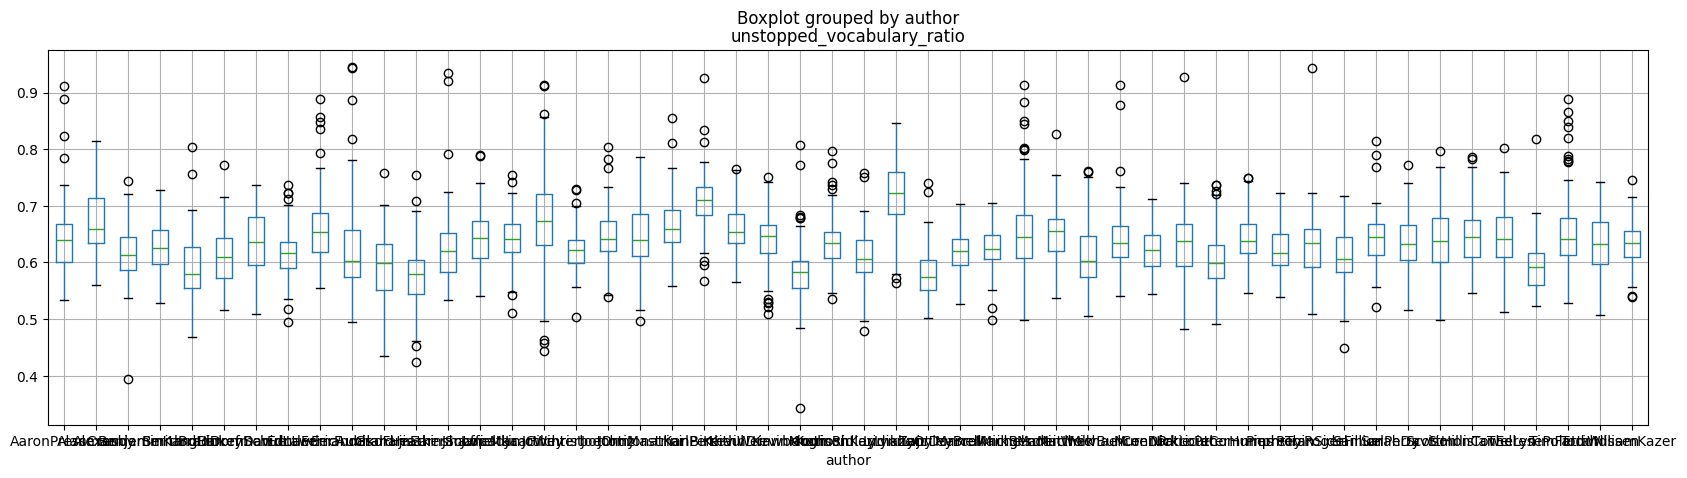

In [181]:
style_df.boxplot(column = 'unstopped_vocabulary_ratio', by = 'author', figsize = (20,5))

In [183]:
#Drop columns with boxplots that do not appear to add value
style_df = style_df.drop(columns = ['vocabulary_ratio', '3q_word_len', '1q_word_len', 'med_word_len', 'char_count', 'cparen_count', 'asterisk_count', 'caret_count', 'percent_count', 'number_count', 'at_count', 'exclamation_count', 'question_count'])

# Exploratory Data Analysis #
We apply a scaler to our data, and begin to perform PCA to reduce the number of features and try to isolate significant features. For each PCA we run, we also generate a pair plot to take a look at clustering. The first pair plot gives some concern with the ability to perform this analysis, there simply isn't enough differentiation between styles when we limit ourselves from using vocabulary. However this project started with the assumption that we were looking at authors that were already frequently misclassified, so we only need to concern ourselves with a tiebreak between 2 authors in order that can be run if we have a low confidence from the previous model. We limit ourselves to the authors Aaron Pressman and Alan Crosby, the most frequently misclassified pair with our old model.

Limiting ourselves to these two authors we can see more differentiation, especially once we run PCA with 2 components. The pair plot should still give pause to this approach though, as while the split between the two categories is clear while labelled, there is no clear density pattern. It is beginning to look like clusters may not adequately model this problem, and that supervised learning will vastly outperform unsupervised learning for this problem.

             0         1         2         3         4         5         6  \
0    -0.981983  0.456648 -0.514480  0.488292  0.210589 -0.465113 -0.408276   
1    -0.064610  1.365301 -0.367252  0.039575  0.097151  0.221401 -0.201221   
2    -1.723332  2.315842  0.068062 -1.365369 -0.362600 -0.382576  0.017869   
3     2.682815 -5.115090  1.135603  0.935791 -0.731165  0.511334  0.289019   
4     0.516347  0.006423  2.258522  1.076460  0.473067  0.570248 -0.680563   
...        ...       ...       ...       ...       ...       ...       ...   
4995 -0.866872  0.223695  1.767516 -0.438648 -0.196718 -0.042048 -0.074843   
4996 -0.051711 -0.553348  0.823537  0.524640 -0.636245 -0.250420  0.283861   
4997  0.811688  0.438700  1.013762 -0.229741 -1.802264  1.153517  1.366719   
4998 -0.957930  1.288898  1.008325  0.695988 -0.730021  0.175993 -0.698235   
4999  0.713946 -0.196944  1.977890  1.158039  0.695049 -0.656442 -0.184841   

             7           y  
0    -0.127088   NickLouth  
1    

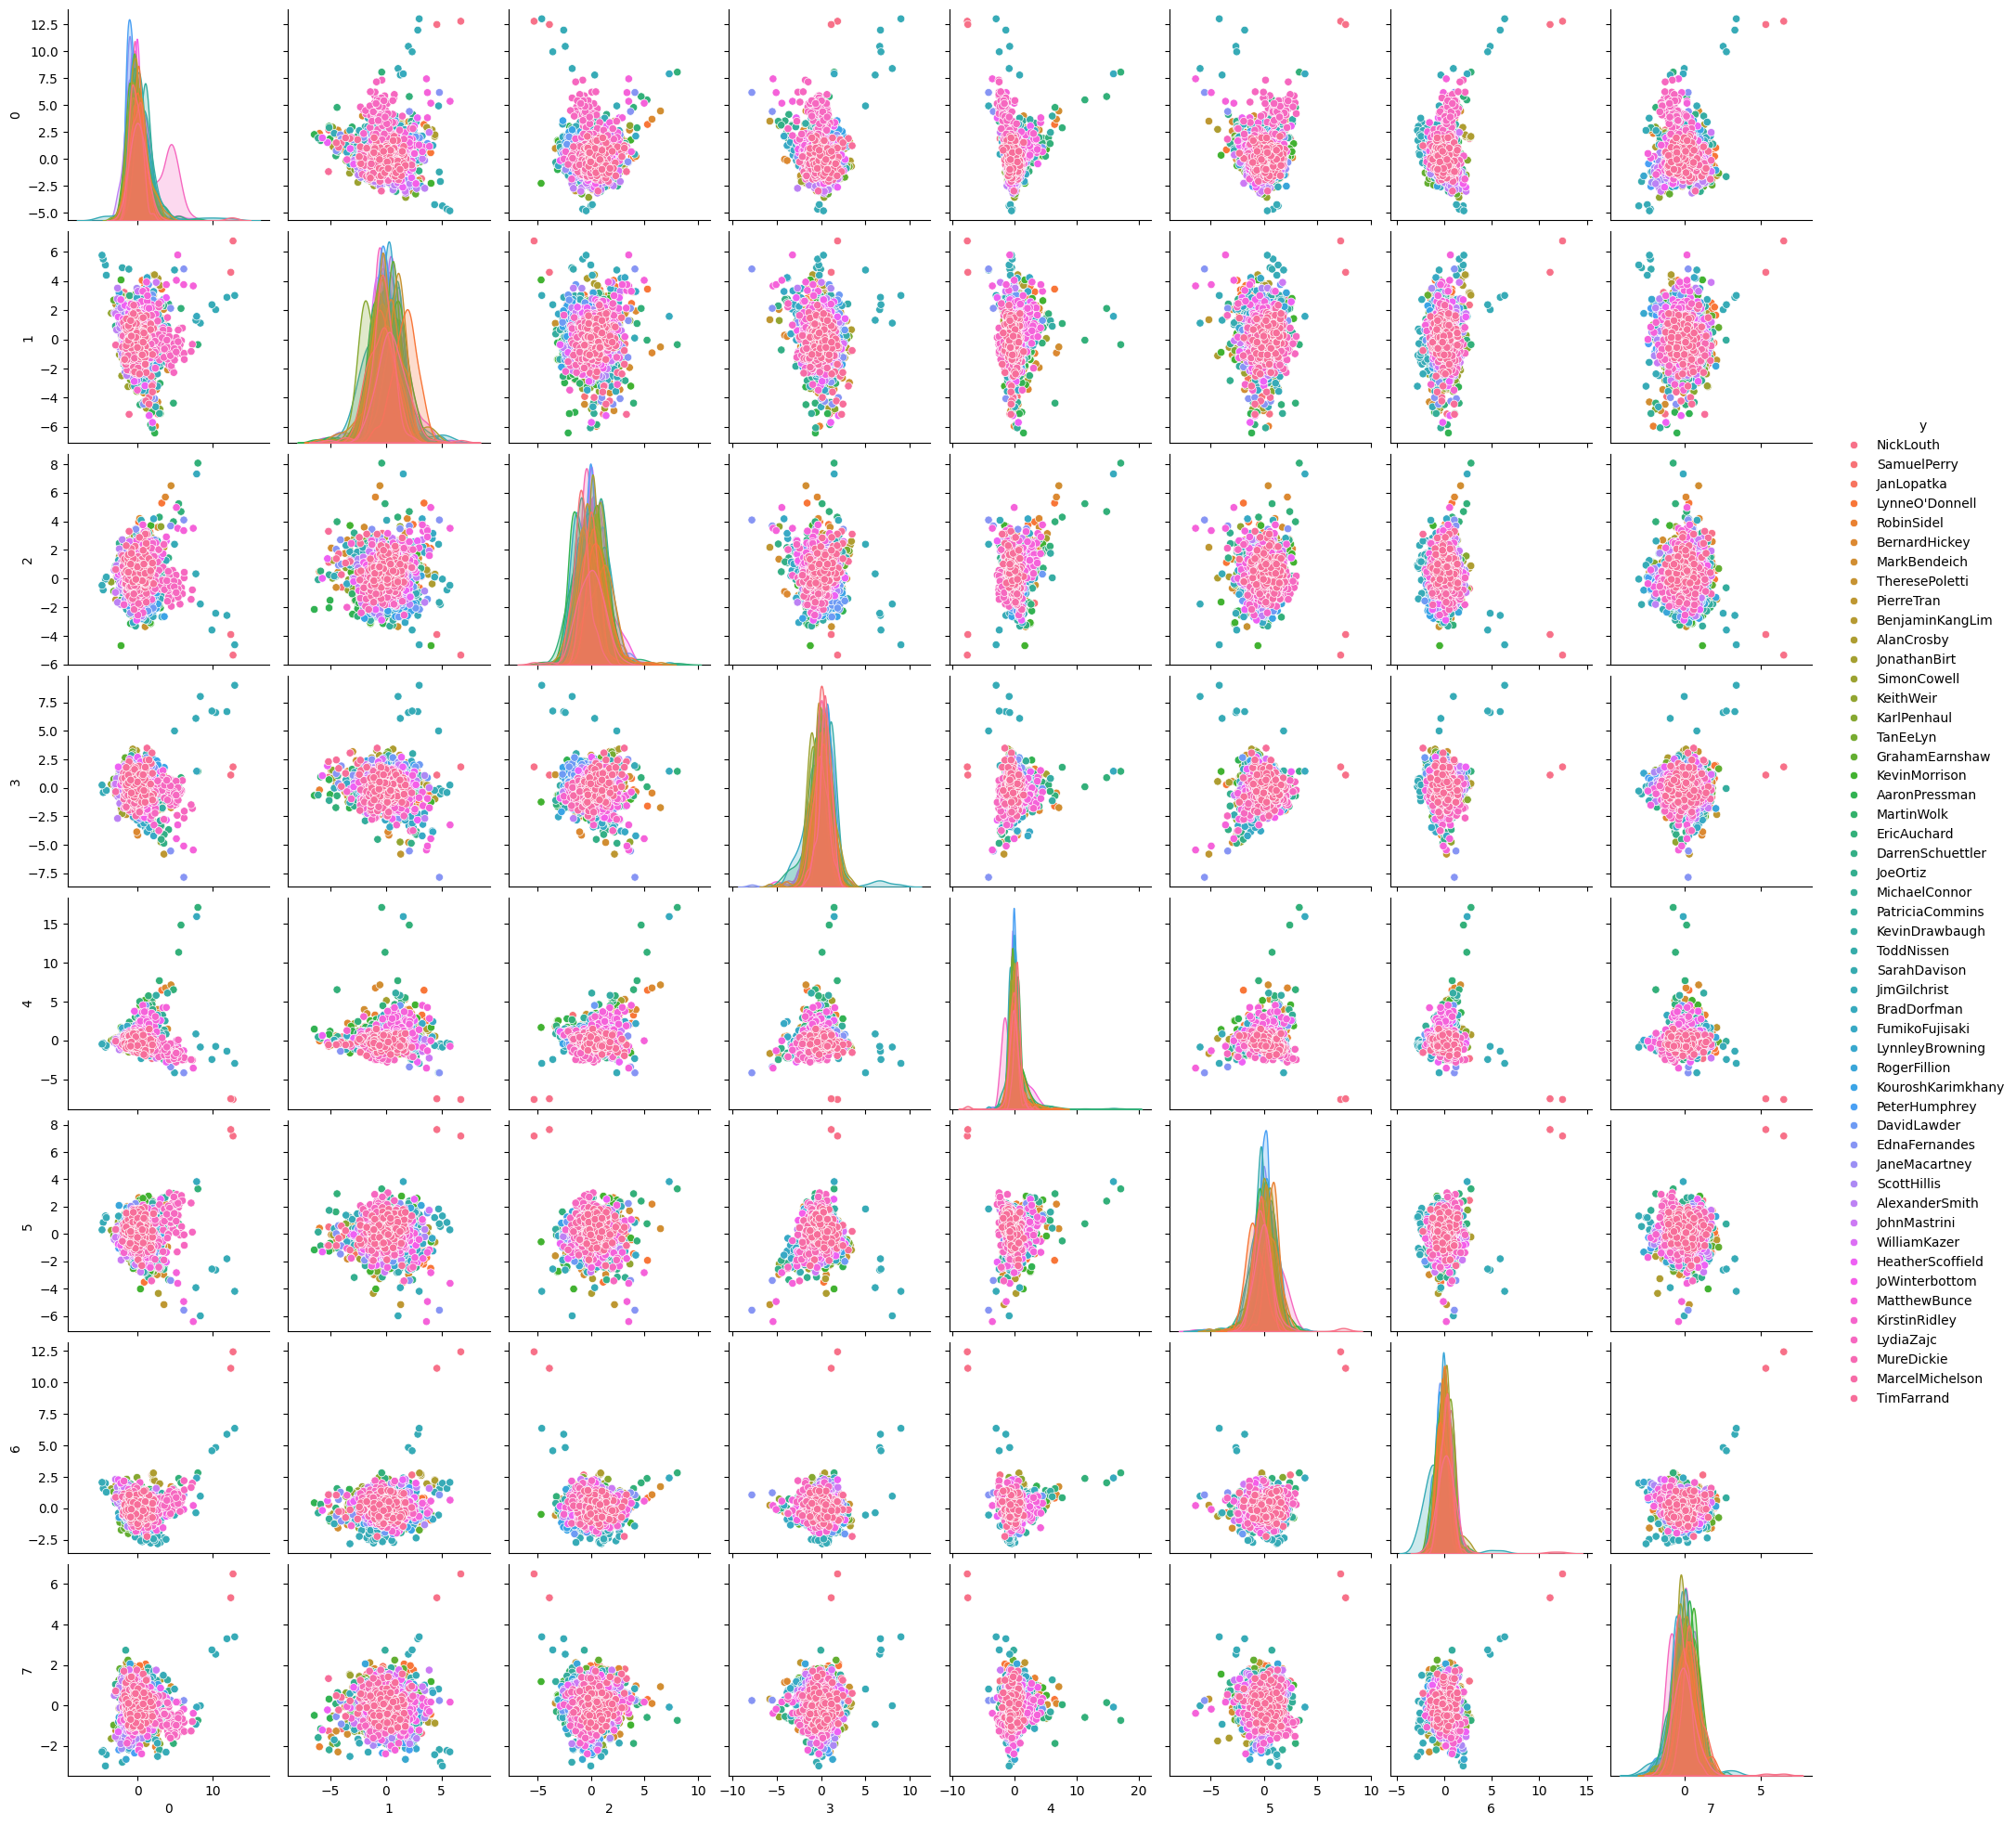

In [338]:
#Pairplot generation
pair_df = style_df
pair_X = pair_df.drop(columns='author')
pair_y = pair_df['author']

scaler = StandardScaler()
scaler.fit(pair_X)
pair_X = scaler.transform(pair_X)

pca = PCA(n_components = 8)
pca.fit(pair_X)
pair_X = pd.DataFrame(pca.transform(pair_X))
pair_X.iloc[:,1] = pair_X.iloc[:,1]*1
graph_df = pair_X
graph_df = graph_df.assign(y = pair_y.values)
print(graph_df)
sns.pairplot(data=graph_df, hue="y")

            0         1         2         3         4         5         6  \
0   -0.059891 -1.881801  0.302998 -0.157792 -0.119881  0.229633 -0.046242   
1    2.767031  0.443956  2.179580  1.426124 -1.270109  0.229877 -0.759262   
2    1.162070  0.241563  1.280600 -0.803104  0.584969 -0.434804 -1.095124   
3   -0.124696  0.656388 -0.168899  0.222898 -0.824952 -0.580746 -0.144808   
4    0.018306  1.814586 -0.039787 -0.804840  0.361500 -0.173220  0.232210   
..        ...       ...       ...       ...       ...       ...       ...   
195 -1.699618 -0.464455  0.380410  0.228891 -0.194282 -1.095716 -0.020679   
196 -0.211098 -0.161049 -0.536240 -0.239255 -0.613420 -0.457591  0.429572   
197  0.154049  0.517975 -1.278182 -1.591453  0.227907 -0.249412 -0.302349   
198 -0.811593 -1.175490 -0.499926 -0.340049 -0.600499 -1.124936  1.124437   
199 -0.943896  0.158999 -0.784549 -0.720870 -0.043521 -0.504818  0.171500   

            7              y  
0    0.614510       TanEeLyn  
1    1.400921

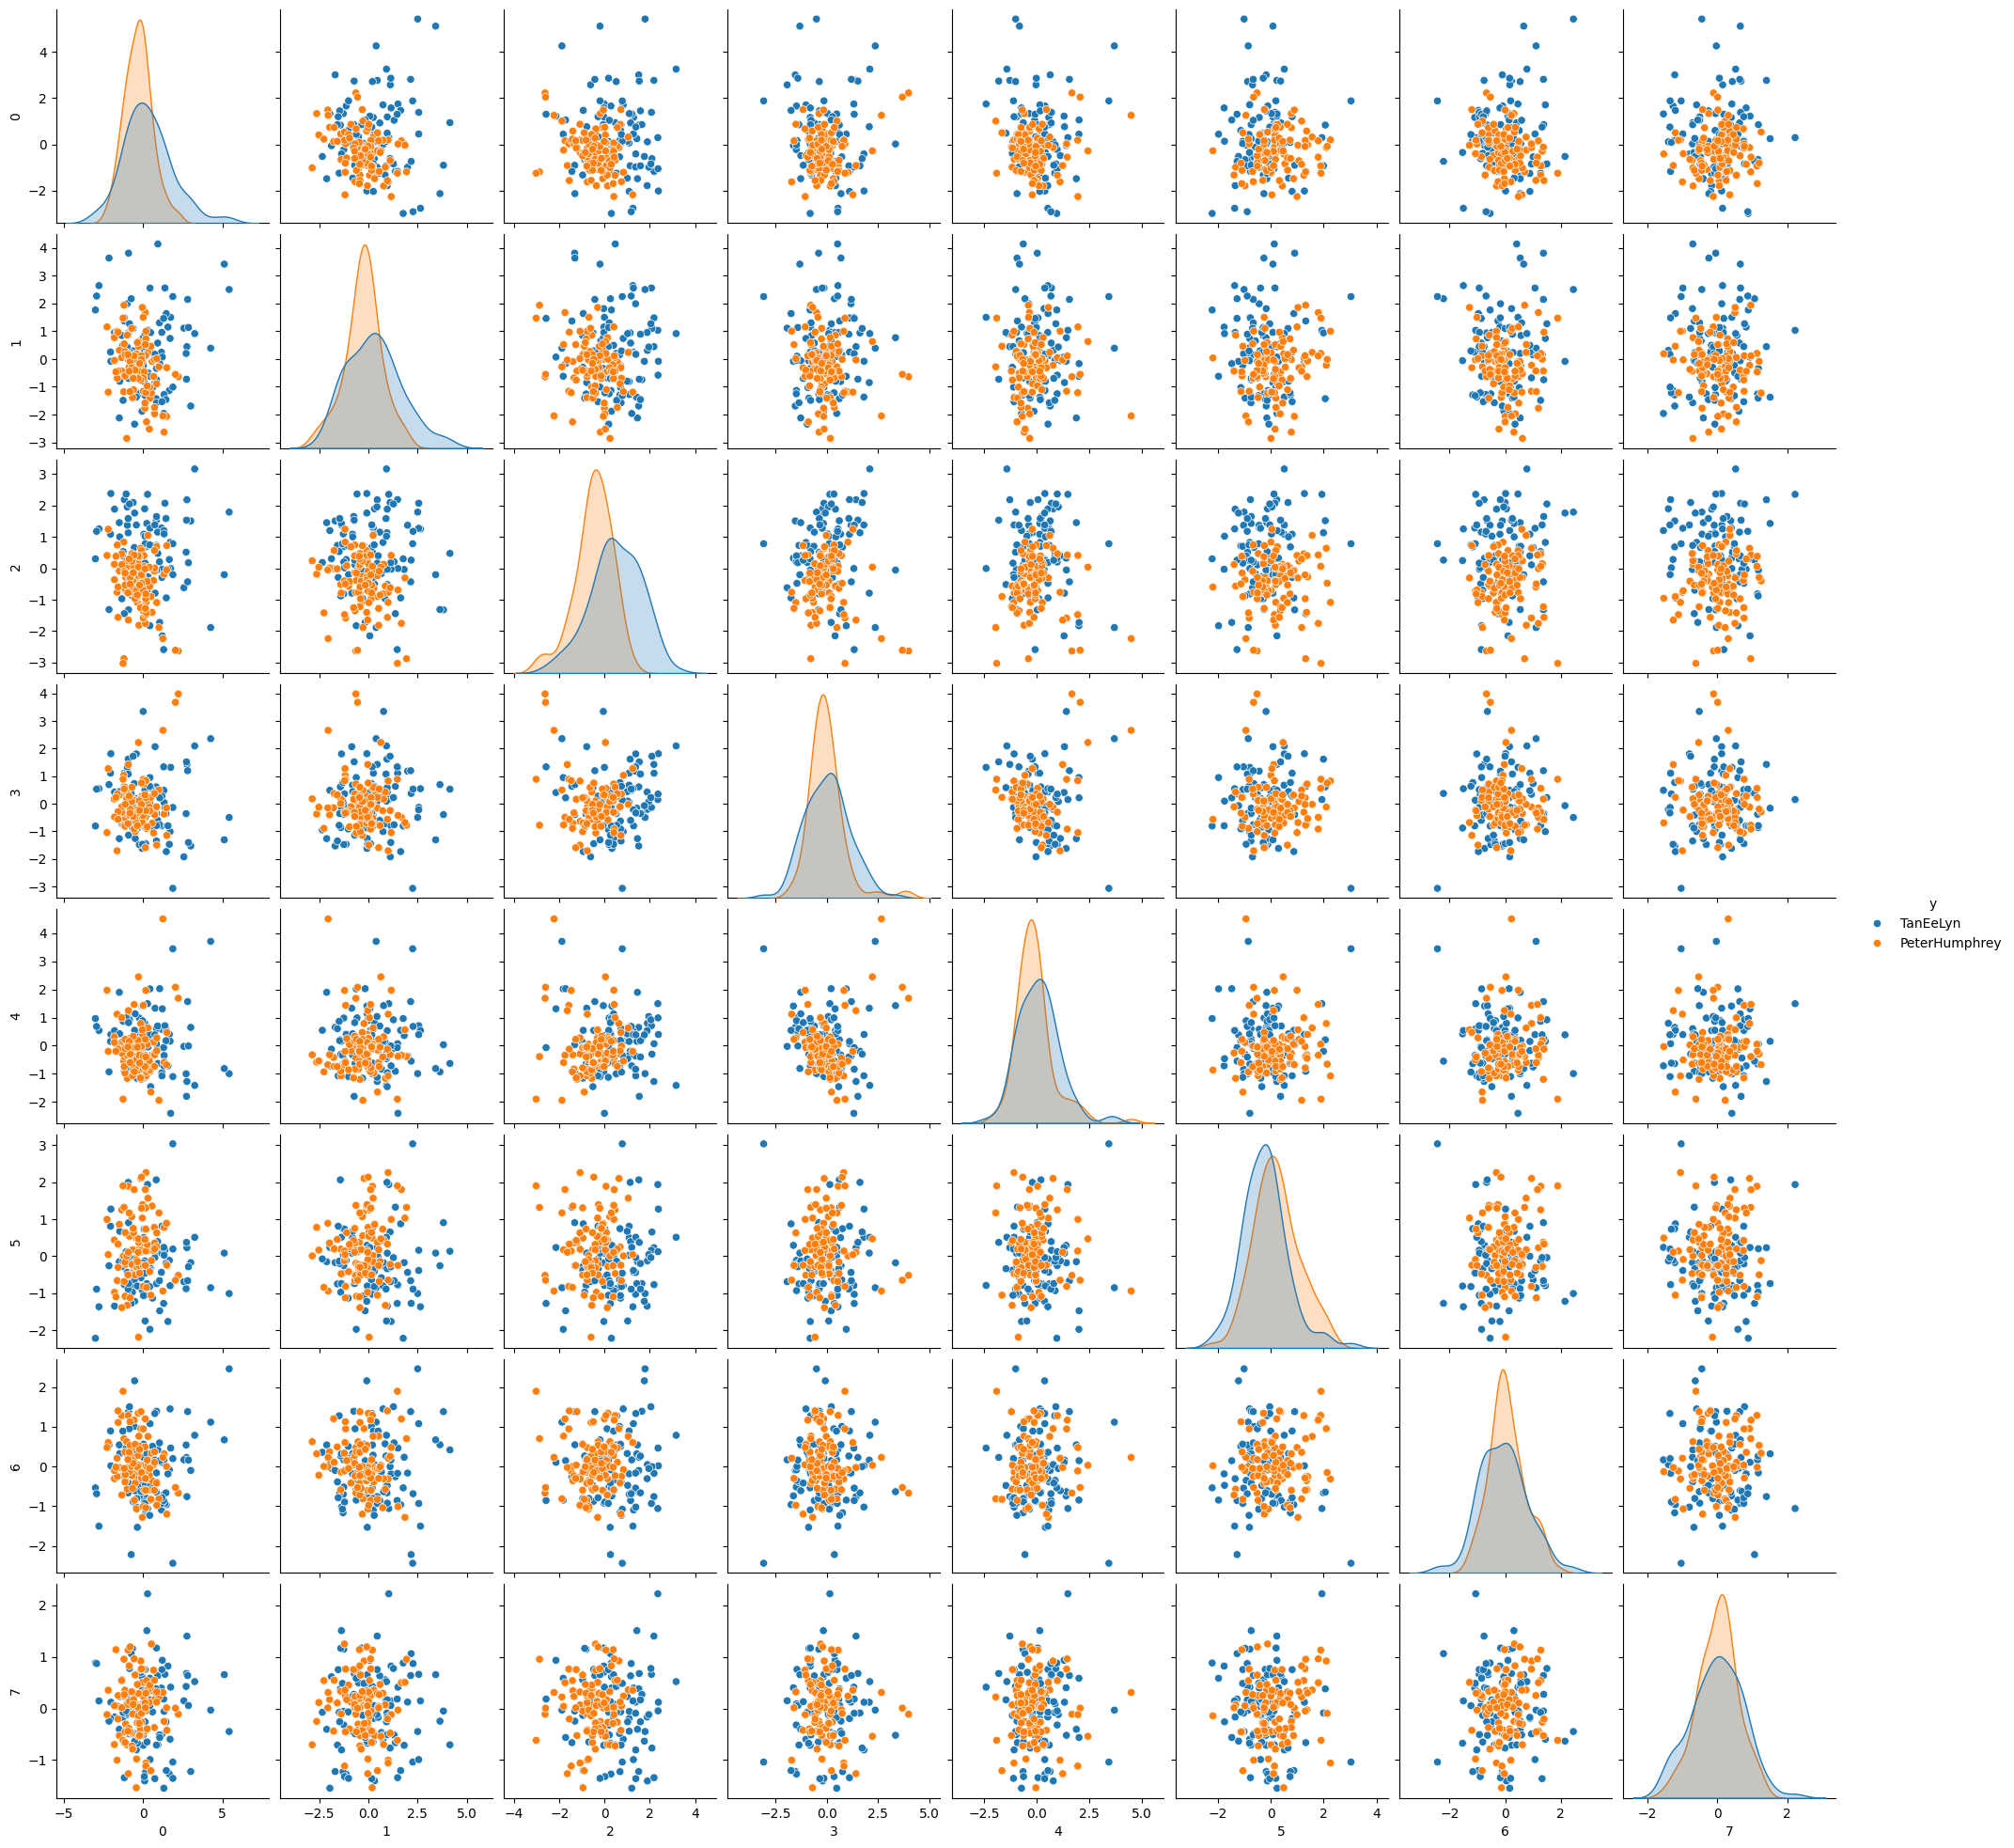

In [358]:
pair_df = style_df[(style_df.author == 'PeterHumphrey') | (style_df.author == 'TanEeLyn')]
pair_X = pair_df.drop(columns='author')
pair_y = pair_df['author']

scaler = StandardScaler()
scaler.fit(pair_X)
pair_X = scaler.transform(pair_X)

pca = PCA(n_components = 8)
pca.fit(pair_X)
pair_X = pd.DataFrame(pca.transform(pair_X))
pair_X.iloc[:,1] = pair_X.iloc[:,1]*1
graph_df = pair_X
graph_df = graph_df.assign(y = pair_y.values)
print(graph_df)
sns.pairplot(data=graph_df, hue="y")

            0         1         2         3              y
0   -1.668071  0.978743 -0.980110 -1.062806     AlanCrosby
1    6.113480 -0.948546  0.732416 -0.492288     AlanCrosby
2   -0.321265  1.419145 -0.812106  0.443337     AlanCrosby
3    5.931114 -0.246841  1.101133 -0.154802     AlanCrosby
4    0.875051  1.250483  0.565582  0.182308     AlanCrosby
..        ...       ...       ...       ...            ...
195  0.992883 -1.282843  3.239053  3.808545  AaronPressman
196 -0.793430 -1.186860 -0.561974  0.218336  AaronPressman
197 -0.991088 -1.373452 -0.662497 -0.454687  AaronPressman
198  0.154940 -0.484400 -1.879278  0.245471  AaronPressman
199 -0.279615 -1.555780  0.357831 -0.299559  AaronPressman

[200 rows x 5 columns]


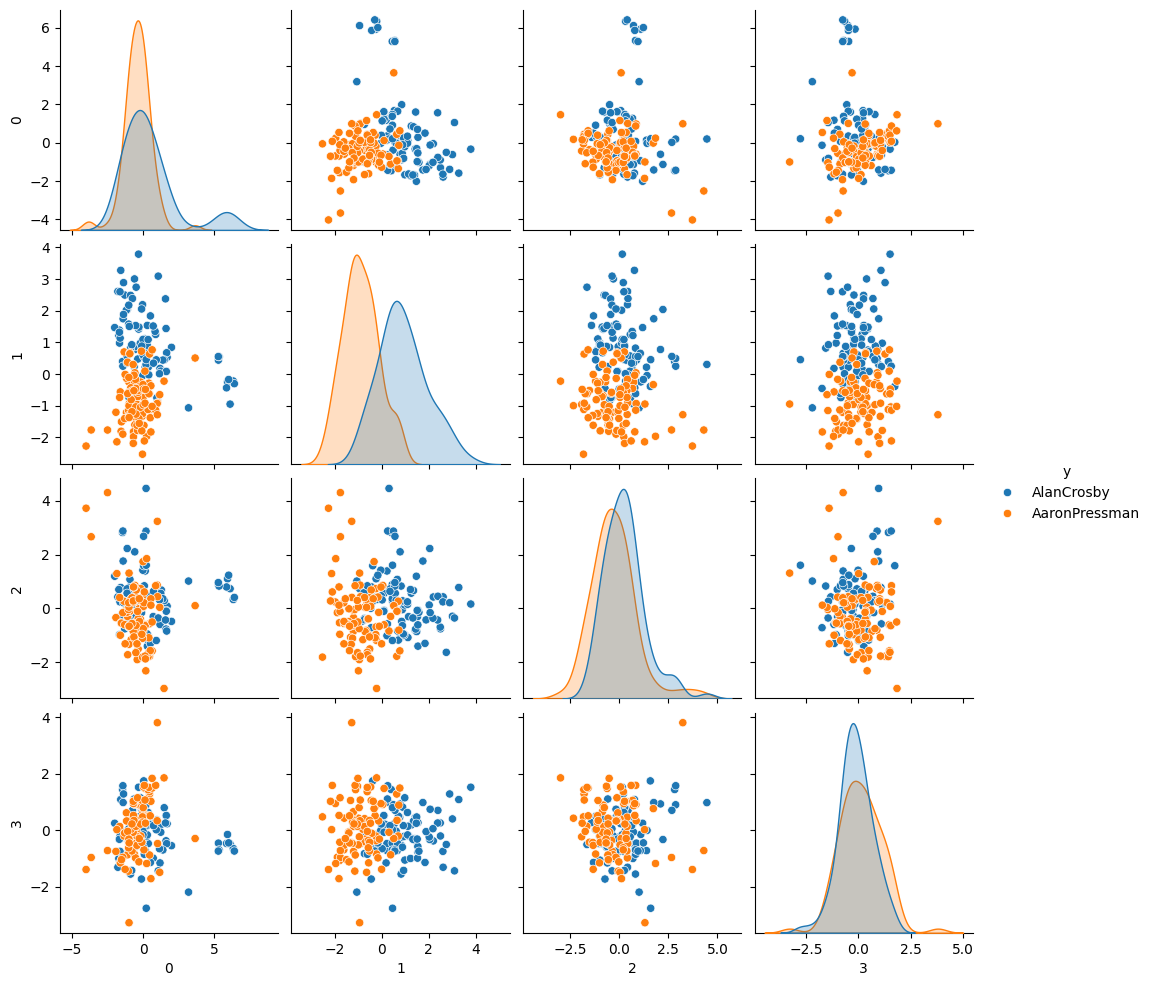

In [360]:
pair_df = style_df[(style_df.author == 'AaronPressman') | (style_df.author == 'AlanCrosby')]
pair_X = pair_df.drop(columns='author')
pair_y = pair_df['author']

scaler = StandardScaler()
scaler.fit(pair_X)
pair_X = scaler.transform(pair_X)

pca = PCA(n_components = 4)
pca.fit(pair_X)
pair_X = pd.DataFrame(pca.transform(pair_X))
pair_X.iloc[:,1] = pair_X.iloc[:,1]*1
graph_df = pair_X
graph_df = graph_df.assign(y = pair_y.values)
print(graph_df)
sns.pairplot(data=graph_df, hue="y")

            0         1              y
0   -1.668071  0.978743     AlanCrosby
1    6.113480 -0.948546     AlanCrosby
2   -0.321265  1.419145     AlanCrosby
3    5.931114 -0.246841     AlanCrosby
4    0.875051  1.250483     AlanCrosby
..        ...       ...            ...
195  0.992883 -1.282843  AaronPressman
196 -0.793430 -1.186860  AaronPressman
197 -0.991088 -1.373452  AaronPressman
198  0.154940 -0.484400  AaronPressman
199 -0.279615 -1.555780  AaronPressman

[200 rows x 3 columns]


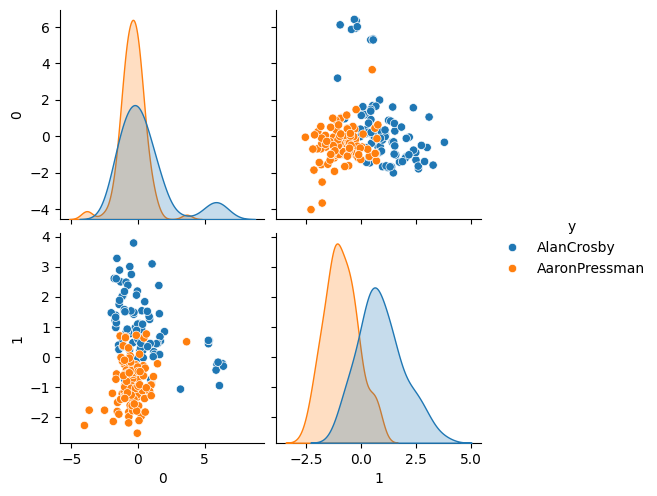

In [361]:
pair_df = style_df[(style_df.author == 'AaronPressman') | (style_df.author == 'AlanCrosby')]
pair_X = pair_df.drop(columns='author')
pair_y = pair_df['author']

scaler = StandardScaler()
scaler.fit(pair_X)
pair_X = scaler.transform(pair_X)

pca = PCA(n_components = 2)
pca.fit(pair_X)
pair_X = pd.DataFrame(pca.transform(pair_X))
pair_X.iloc[:,1] = pair_X.iloc[:,1]*1
graph_df = pair_X
graph_df = graph_df.assign(y = pair_y.values)
print(graph_df)
sns.pairplot(data=graph_df, hue="y")

# Models #
Informed by our previous analysis, we will be modeling two authors to simulate a tie breaker in the previous model, and first running PCA with two components. We will test both a K-Means model and a DBSCAN model, along with a Random Forest for comparison to a supervised model.

K-Means: This algorithm attempts to assign k centroids and minimize the distance of the points associated with that centroid. We first test for our value of K, using the "elbow" method by plotting the error for each k between 1 and 50, and noticing that most of our error is explained within the first 3 centroids.

DBSCAN: The DBSCAN algorithm chooses adjacent densely packed points, and has an advantage over K-Means that it does not rely on the shape or size of clusters being similar. Additionally it is not necessary to choose K ahead of time, the number of clusters is determined by the DBSCAN algorithm.

Random Forest: This is our baseline algorithm, allowing ourselves labelled data and optimizing parameters with GridSearchCV.

In [362]:
#Train test split
pair_df = style_df[(style_df.author == 'AaronPressman') | (style_df.author == 'AlanCrosby')]
pair_X = pair_df.drop(columns='author')
pair_y = pair_df['author']

scaler = StandardScaler()
scaler.fit(pair_X)
pair_X = scaler.transform(pair_X)

style_X_train, style_X_test, style_y_train, style_y_test = train_test_split(pair_X, pair_y, stratify = pair_y)

pca = PCA(n_components=2)

In [363]:
errors = []
for k in range(1,50):
    ac_model = KMeans(n_clusters=k, max_iter=250)
    ac_model.fit(style_X_train)
    errors.append(ac_model.inertia_)

<Axes: >

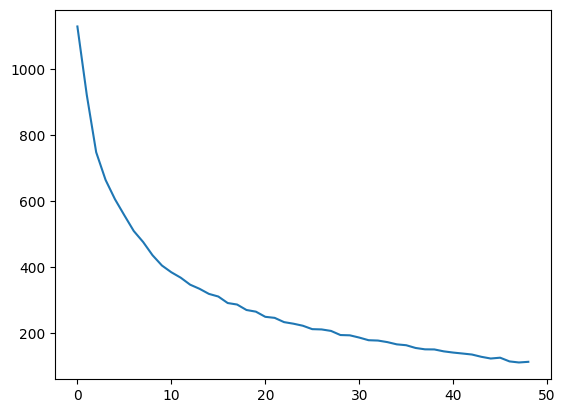

In [364]:
sns.lineplot(errors)

In [365]:
km_model = KMeans(n_clusters=3)
km_model.fit(style_X_train)

km_train_predictions = km_model.predict(style_X_train)
km_test_predictions = km_model.predict(style_X_test)

km_train_purity = homogeneity_score(style_y_train, km_train_predictions)
km_test_purity = homogeneity_score(style_y_test, km_test_predictions)
print(km_train_purity)
print(km_test_purity)

0.5540610464362034
0.4522445900056777


In [366]:
dbscan_model = DBSCAN(eps=2, min_samples=10)
dbscan_train_predictions = dbscan_model.fit_predict(style_X_train)
dbscan_train_purity = homogeneity_score(style_y_train, dbscan_train_predictions)
dbscan_test_predictions = dbscan_model.fit_predict(style_X_test)
dbscan_test_purity = homogeneity_score(style_y_test, dbscan_test_predictions)
print(dbscan_train_purity)
print(dbscan_test_purity)

0.020352970640325232
0.28070352180768093


In [367]:
#Random Forest Model
rf_grid = {'n_estimators': [50, 100, 200, 400],
'max_depth': [5, 10, 15, 20],
'max_features': ['sqrt','log2']
}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_grid)
rf_grid_search.fit(style_X_train, style_y_train)
rf_grid_search.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}

In [368]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt')
rf_model.fit(style_X_train, style_y_train)

RandomForestClassifier(max_depth=20)

In [369]:
rf_train_predictions = rf_model.predict(style_X_train)
rf_test_predictions = rf_model.predict(style_X_test)
rf_train_accuracy = accuracy_score(style_y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(style_y_test, rf_test_predictions)
print(rf_train_accuracy)
print(rf_test_accuracy)

1.0
0.94


# Results and Analysis #
First, a couple notes: Strictly Train/Test are not needed for unsupervised models, but since we wanted to use the same amount of data as in our supervised model it gives an adequate comparison. Additionally since accuracy cannot be computed in unsupervised training without a corresponding source of true values, we instead chose to use homogeneity for the unsupervised models. This is a measure of how pure the node is, and theoretically should correspond to how accurate we would be if we appropriately assigned the labels to the provided predictions.

We see that DBSCAN produced very low and volatile results, producing homogeneity of only 28% with most of the data, and almost 0% on the test set, indicating that almost all data was grouped into a single category.

K-Means performed better, with 55% and 45% homogeneity respectively, an improvement, but not sufficient for effective classification.

The Random Forest model was expected to perform better as it had the advantage of seeing the classifications during training, and it outperforms the unsupervised models substantially, with a test accuracy of 96%.

               Train Homogeneity  Test Homogeneity
K Means                 0.554061          0.452245
DBSCAN                  0.020353          0.280704
Random Forest           1.000000          0.940000


<Axes: >

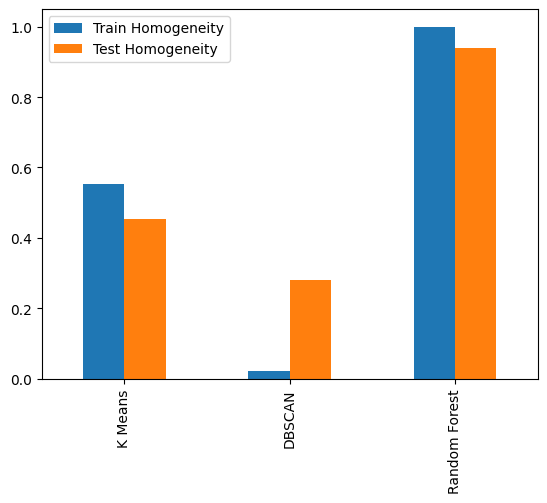

In [370]:
acc_dict = {'Train Homogeneity': [km_train_purity, dbscan_train_purity, rf_train_accuracy],
            'Test Homogeneity': [km_test_purity, dbscan_test_purity, rf_test_accuracy]}
acc_index = ['K Means','DBSCAN','Random Forest']
results_df = pd.DataFrame(acc_dict, index=acc_index)
print(results_df)
results_df.plot.bar()

In [371]:
rf_train_predictions = rf_model.predict(style_X_train)
rf_test_predictions = rf_model.predict(style_X_test)
rf_train_accuracy = accuracy_score(style_y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(style_y_test, rf_test_predictions)
print(rf_train_accuracy)
print(rf_test_accuracy)

1.0
0.94


# Discussion and Conclusion #
Unfortunately we have to conclude that this approach is not an effective one for author identification. The categories appear to be linearly seperable, but the density is simply too consistent to effectively generate clusters from unsupervised learning. A positive outcome however is that our baseline supervised model performed extremely well out of the box. The missclassification error in our previous model between these two similar authors was 13%, while the model here misclassifies only 6% of those cases.

This supervised alternative would be a very interesting case for additional research, it implies that other supervised models could prove effective, and we would like to investigate creating a neural network to process these values and see if we can handle the numerous authors instead of just inspecting them pairwise. If successful it could then be integrated with the word choice model developed previously to improve accuracy of classification.